### For this assignment, we have used Microsoft S&P stock profile for time series analysis using ARIMA and SARIMA models.

In [4]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()
from time import time
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
tickersymbol = 'MSFT'

In [4]:
#get data on this ticker
tickerData = yf.Ticker(tickersymbol)

In [5]:
ticker = tickerData.history(interval='1d', start='2019-1-1', end='2020-4-10')

In [6]:
ticker

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-12-31,97.311033,98.377429,96.494425,97.580032,33173800,0.0,0
2019-01-02,95.639380,97.752954,95.053342,97.147705,35329300,0.0,0
2019-01-03,96.167778,96.254246,93.381697,93.573845,42579100,0.0,0
2019-01-04,95.802704,98.483106,95.043737,97.925888,44060600,0.0,0
2019-01-07,97.647259,99.213225,97.013190,98.050758,35656100,0.0,0
...,...,...,...,...,...,...,...
2020-04-03,151.623449,153.852342,148.778673,150.381912,41243300,0.0,0
2020-04-06,156.726462,162.767932,154.047874,161.565506,67111700,0.0,0
2020-04-07,165.788638,166.189451,159.600523,159.825378,62769000,0.0,0


## SInce, we are interested in closing price of the Microsoft stock and the date associated with it;
## We are dropping other columns for our further analysis.

In [7]:
tickerDf = ticker.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis = 1)

In [8]:
tickerDf.head()

,Close
Date,
2018-12-31,97.580032
2019-01-02,97.147705
2019-01-03,93.573845
2019-01-04,97.925888
2019-01-07,98.050758


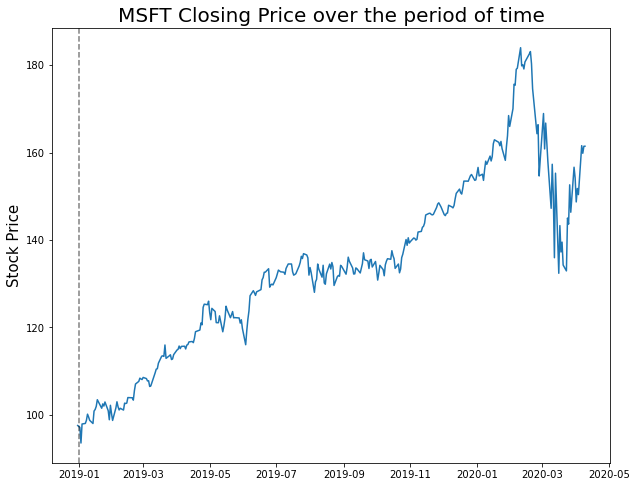

In [9]:
plt.figure(figsize = (10,8))
plt.plot(tickerDf.Close)
plt.title('MSFT Closing Price over the period of time', fontsize = 20)
plt.ylabel('Stock Price', fontsize = 15)
for year in range(2019, 2020):
    plt.axvline(pd.to_datetime(str(year)), color = 'k', linestyle = '--', alpha = 0.5)

## Testing Stationarity

In [10]:
test_result=adfuller(tickerDf['Close'])

In [13]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(close):
    result=adfuller(close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [15]:
adfuller_test(tickerDf['Close'])

ADF Test Statistic : -1.4963429178623429
p-value : 0.53531966317778
#Lags Used : 9
Number of Observations Used : 312
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Since, it is non-stationary, we need to transform the data using first differencing technique.

## FIrst Differencing

In [18]:
first_diffs = tickerDf.Close.values[1:] - tickerDf.Close.values[:-1] 
first_diffs = np.concatenate([first_diffs, [0]])

In [19]:
#set first difference as variable in dataframe
tickerDf['First_Difference'] = first_diffs

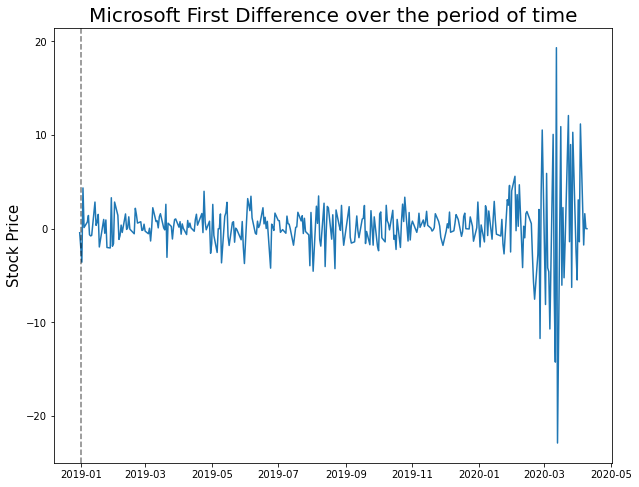

In [20]:
plt.figure(figsize = (10,8))
plt.plot(tickerDf.First_Difference)
plt.title('Microsoft First Difference over the period of time', fontsize = 20)
plt.ylabel('Stock Price', fontsize = 15)
for year in range(2019, 2020):
    plt.axvline(pd.to_datetime(str(year)), color = 'k', linestyle = '--', alpha = 0.5)

## Again, testing Stationarity

In [21]:
## Again test dickey fuller test
adfuller_test(tickerDf['First_Difference'].dropna())

ADF Test Statistic : -4.883835355282642
p-value : 3.7491024554296995e-05
#Lags Used : 8
Number of Observations Used : 313
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


#### The data is stationary now and ready, to be analysed.

## ACF & DACF 

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

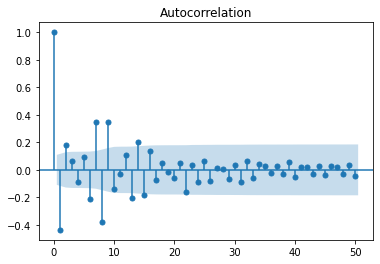

In [13]:
acf_plot = plot_acf(tickerDf.First_Difference, lags = 50)

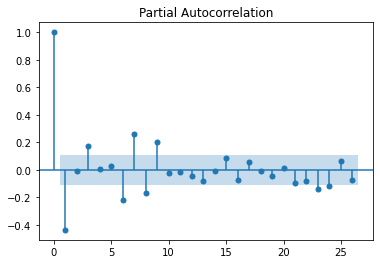

In [14]:
pacf_plot = plot_pacf(tickerDf.First_Difference)

#### From pACF curve, we infer that an AR model can be run at 1, 3, 6, 7, 8, 9, 23

## Splitting dataset for training and testing the model(s)

In [15]:
print(tickerDf.shape)
train=tickerDf.iloc[:-30]
test=tickerDf.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(322, 2)
(292, 2) (30, 2)
Close               158.378571
First_Difference     10.538361
Name: 2020-02-28 00:00:00, dtype: float64 Close               161.438385
First_Difference      0.000000
Name: 2020-04-09 00:00:00, dtype: float64


## ARIMA Modeling

In [48]:
import warnings
warnings.filterwarnings("ignore")


model=ARIMA(train['First_Difference'],order=(1,1,7))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.First_Difference   No. Observations:                  291
Model:                 ARIMA(1, 1, 7)   Log Likelihood                -593.696
Method:                       css-mle   S.D. of innovations              1.842
Date:                Sun, 28 Aug 2022   AIC                           1207.393
Time:                        20:25:38   BIC                           1244.126
Sample:                             1   HQIC                          1222.108
                                                                              
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0004      0.001     -0.351      0.725      -0.003       0.002
ar.L1.D.First_Difference    -0.6566      0.167     -3.931      0.000      -0.984      -0.329
ma.L1.D.First_Difference    -0.3710      0.170     -2.178      0.029      -0.705      -0.037
ma.L2.D.First_Difference    -0.6545      0.172     -3.800      0.000      -0.992      -0.317
ma.L3.D.First_Difference     0.1640      0.077      2.136      0.033       0.014       0.315
ma.L4.D.First_Difference    -0.0827      0.089     -0.928      0.353      -0.257       0.092
ma.L5.D.First_Difference    -0.0906      0.095     -0.957      0.339      -0.276       0.095
ma.L6.D.First_Difference    -0.1049      0.074     -1.422      0.155      -0.250       0.040
ma.L7.D.First_Difference     0.1397      0.077      1.814      0.070      -0.011       0.291
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5230           +0.0000j            1.5230            0.5000
MA.1           -1.0915           -0.0000j            1.0915           -0.5000
MA.2           -0.9684           -1.0728j            1.4453           -0.3669
MA.3           -0.9684           +1.0728j            1.4453            0.3669
MA.4            0.5789           -1.2655j            1.3916           -0.1817
MA.5            0.5789           +1.2655j            1.3916            0.1817
MA.6            1.0000           -0.0000j            1.0000           -0.0000
MA.7            1.6216           -0.0000j            1.6216           -0.0000
-----------------------------------------------------------------------------
"""

In [49]:
start=len(train)
end=len(train)+len(test)-1

<AxesSubplot:xlabel='Date'>

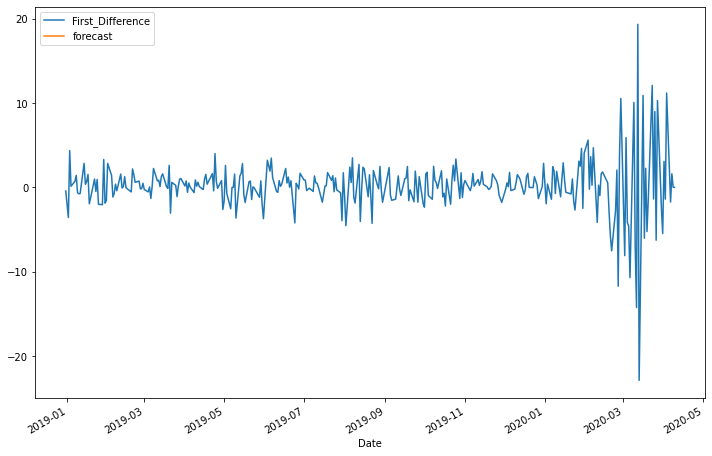

In [55]:
tickerDf['forecast']=model_fit.predict(start = start, end = end)
tickerDf[['First_Difference','forecast']].plot(figsize=(12,8))

## SARIMA Modeling

In [24]:
modelS = SARIMAX(tickerDf['First_Difference'],order=(2, 1, 0),seasonal_order=(1,1,1,30))
results = modelS.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     First_Difference   No. Observations:                  322
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 30)   Log Likelihood                -791.992
Date:                              Sun, 28 Aug 2022   AIC                           1593.984
Time:                                      19:58:16   BIC                           1612.351
Sample:                                           0   HQIC                          1601.342
                                              - 322                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0460      0.029    -36.156      0.000      -1.103      -0.989
ar.L2         -0.5063      0.028    -18.022      0.000      -0.561      -0.451
ar.S.L30      -0.0924      0.192     -0.481      0.631      -0.469       0.284
ma.S.L30      -0.6074      0.192     -3.166      0.002      -0.983      -0.231
sigma2        12.6983      0.612     20.742      0.000      11.498      13.898
===================================================================================
Ljung-Box (L1) (Q):                   3.62   Jarque-Bera (JB):               383.26
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               6.01   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

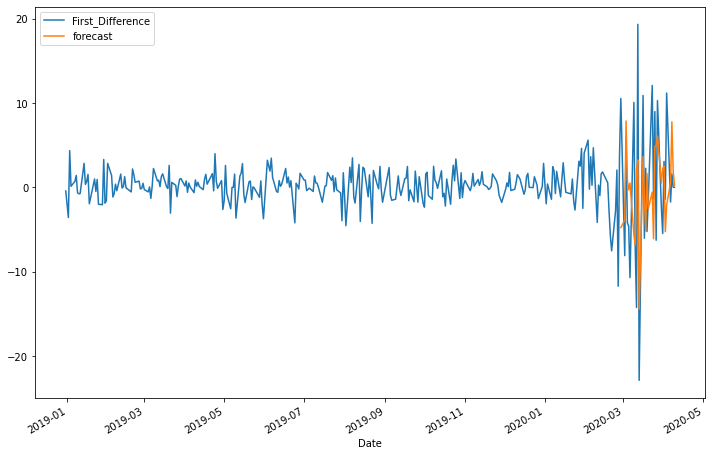

In [35]:
tickerDf['forecast']=results.predict(start= start, end =end)
tickerDf[['First_Difference','forecast']].plot(figsize=(12,8))

#### Since, we can see that there's no prediction for test dataset in case of ARIMA and, there's a prediction in case of SARIMA;

## Hence, we conclude that our dataset is seasonal in nature.